# Linear Regression
Haytham Mohamed

INFS 890 - Spring 2020

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVR
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn import preprocessing, metrics, feature_selection
from datetime import datetime
from scipy import stats
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV

sns.set()
sns.set(color_codes=True)
#sns.set_color_codes()

pd.options.display.max_rows = 15
pd.options.display.float_format = '{:,.4f}'.format

Set this flag to True if you're using reduction feature using FCA, otherwise set it to False

In [47]:
# 1- read data file
# 1- read processed file
home_dir = '/Users/hmohamed/github/data-research-spring2020/sock-shop'
file_dir = home_dir + '/processed-data/'

#data_file = 'order_flow_cleanup_data.csv'
data_file = 'order_flow_normalized_data.csv'
#data_file = 'order_flow_standardized_data.csv'
#data_file = 'order_flow_factored_data.csv'



test_split = 0.1

In [48]:
def read_df(file_dir, data_file, timeseries=True):
    df = pd.read_csv(file_dir + data_file)
    if timeseries:
        df = to_time_series(df)
    return df

def to_time_series(df, index_col_name='date'):
    df[index_col_name] = pd.to_datetime(df[index_col_name])
    df.set_index(index_col_name, inplace=True)
    df.sort_index(inplace=True)
    return df

def merge(df, series):
    return pd.merge_asof(df, series, left_index=True, right_index=True, tolerance=pd.Timedelta('1 second')).bfill()    


In [49]:
data = read_df(file_dir, data_file, True)
data = data.reset_index(drop=True)
data.head(5)

front-end_cpu_use  orders_cpu_use  orders-db_cpu_use  user_cpu_use  \
0             0.0700          0.0200             0.0100        0.0200   
1             0.0600          0.0300             0.0100        0.0200   
2             0.0600          0.0300             0.0100        0.0200   
3             0.0900          0.0300             0.0100        0.0200   
4             0.1100          0.0400             0.0100        0.0300   

   user-db_cpu_use  shipping_cpu_use  payment_cpu_use  carts_cpu_use  \
0           0.0200            0.0100           0.0100         0.1200   
1           0.0200            0.0100           0.0100         0.1400   
2           0.0200            0.0100           0.0100         0.1500   
3           0.0200            0.0100           0.0100         0.0600   
4           0.0300            0.0100           0.0100         0.1100   

   carts-db_cpu_use  front-end_pods  orders_pods  user_pods  shipping_pods  \
0            0.1600          1.0000       1.0000     1.0000         1.0000   
1            0.1700          1.0000       1.0000     1.0000         1.0000   
2            0.1400          1.0000       1.0000     1.0000         1.0000   
3            0.1900          1.0000       1.0000     1.0000         1.0000   
4            0.3200          1.0000       1.0000     1.0000         1.0000   

   payment_pods  carts_pods  nodes_cpu_use  orders_req  orders_ltcy  
0        1.0000      1.0000         1.1800      0.4000       0.6325  
1        1.0000      1.0000         1.1800      0.4400       0.6245  
2        1.0000      1.0000         1.1500      0.3600       0.6164  
3        1.0000      1.0000         1.5400      0.4000       0.5568  
4        1.0000      1.0000         2.3500      0.7800       0.5292

In [50]:
data.shape

(1499, 18)

In [51]:
targets = data['orders_ltcy']

inputs = data.drop(['orders_ltcy'], axis=1)
#inputs = inputs.drop(['date'], axis=1)

n_features = inputs.values.shape[1]

#inputs_scaled = scaler.fit_transform(inputs)
#x_train, x_test, y_train, y_test = train_test_split(inputs_scaled, targets, test_size=0.2, random_state=365)

x_train, x_test, y_train, y_test = \
    train_test_split(inputs, targets, test_size=test_split, shuffle=False, random_state=365)

# for better convergence and result scale target to values between 0 - 1
y_train_max = y_train.max()
y_test_max = y_test.max()

y_train = y_train / y_train_max
y_test = y_test / y_test_max

print("there are {} features".format(n_features))

there are 17 features


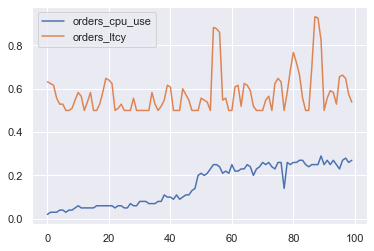

In [52]:
#plt.scatter(data['orders_cpu_use'], data['orders_ltcy'])
#plt.xlabel('orders_cpu_use', size=18)
#plt.ylabel("orders_ltcy", size=18)
#plt.show()

# plot cpu vs latency 
plt.plot(data['orders_cpu_use'][:100], label='orders_cpu_use')
plt.plot(data['orders_ltcy'][:100], label='orders_ltcy')
plt.legend()
plt.show()

#ax = sns.regplot(x=data['orders_cpu_use'], y=data['orders_ltcy'], color='g')


# Model

In [53]:
# start:  search grid

# SVR
reg = LinearSVR(random_state=365, verbose=0)   #(C=0.1, random_state=365, verbose=0)

# standardize the features
scaler = StandardScaler()
#scaler.fit(x_train.values.reshape(-1,n_features))

#model = LassoCV(fit_intercept=False,n_jobs=-1,random_state=0,selection='random',positive=False,cv=10)
model = RandomForestRegressor(n_jobs=-1, max_depth=10, n_estimators=20)
sfm = SelectFromModel(model)


pipe = Pipeline(steps=[
    ('selector', sfm),
    ('scaler', scaler), 
    ('reg', reg)
])

kfold = KFold(n_splits=10, shuffle=True)

param_grid = {
    #'selector__threshold': [0.1, 0.05, 0.02, 0.001]  # with lasso
    'selector__threshold': ['1*mean', '0.8*mean', '0.6*mean', '0.3*mean', '0.1*mean','0.05*mean', '0.02*mean', '0.01*mean', '0.001*mean'] # with tree
    ,'reg__C': [.01, .05, .1]
}

search = GridSearchCV(pipe, param_grid, scoring='neg_mean_squared_error'
                      , return_train_score= True, cv=kfold, verbose=1, n_jobs=-1)

#scores = cross_val_score(pipe, x_train, y_train, cv=kfold, n_jobs=-1
        #, verbose=3, scoring='neg_mean_squared_error')



In [54]:
import sklearn 
print(sklearn.__version__)

search.fit(x_train, y_train)

0.22.2.post1
Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:   15.5s finished
/opt/anaconda3/envs/infs890/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('selector',
                                        SelectFromModel(estimator=RandomForestRegressor(bootstrap=True,
                                                                                        ccp_alpha=0.0,
                                                                                        criterion='mse',
                                                                                        max_depth=10,
                                                                                        max_features='auto',
                                                                                        max_leaf_nodes=None,
                                                                                        max_samples=None,
                                                                  

# Best Model

In [55]:
estimator = search.best_estimator_

score = search.best_score_
print("Best CV test score = %0.4f:" % score)

params = search.best_params_
print("Best CV params = {}".format(params))

print("")
all_training_scores = search.cv_results_
#print("\ncross_validation:\n", all_training_scores , "\n")

print('mean train scores')
print(all_training_scores['mean_train_score'])

print('mean test scores')
print(all_training_scores['mean_test_score'])


Best CV test score = -0.0292:
Best CV params = {'reg__C': 0.1, 'selector__threshold': '0.01*mean'}

mean train scores
[-0.03933861 -0.03319133 -0.03080916 -0.03069938 -0.03009774 -0.02889847
 -0.02842454 -0.02842723 -0.02841416 -0.03627517 -0.03225761 -0.03089212
 -0.03077609 -0.03027094 -0.02870956 -0.02828307 -0.02827563 -0.02827783
 -0.03561758 -0.03131997 -0.03083327 -0.03083513 -0.02995887 -0.02897137
 -0.02828578 -0.02820011 -0.02820511]
mean test scores
[-0.03938359 -0.03346782 -0.03135671 -0.03141731 -0.03085465 -0.02956756
 -0.02916421 -0.02916047 -0.02916145 -0.0359489  -0.03248874 -0.03150861
 -0.03158061 -0.03093271 -0.02968323 -0.02920313 -0.02919175 -0.02919841
 -0.03646302 -0.03209592 -0.03144016 -0.03155639 -0.0307379  -0.0297862
 -0.02928195 -0.02915581 -0.0291863 ]


# Features Selected

In [56]:
best_threshold = params['selector__threshold']

print('best selector threshold {}'.format(best_threshold))

#sfm = SelectFromModel(clf,threshold=best_threshold)

sfm = pipe['selector']
sfm.threshold = best_threshold

selectedFeatures = sfm.fit(x_train, y_train).transform(x_train)
print('{} features selected'.format(selectedFeatures[1].shape[0]))

feature_list = x_train.columns[sfm.get_support()]
features = ''
features = ', '.join(feature_list)
#features

reduced_x_train = x_train[feature_list]
#reduced_x_train.head(2)
print('')
for feature in reduced_x_train.columns.values:
    print(feature)

best selector threshold 0.01*mean
16 features selected

front-end_cpu_use
orders_cpu_use
orders-db_cpu_use
user_cpu_use
user-db_cpu_use
shipping_cpu_use
payment_cpu_use
carts_cpu_use
carts-db_cpu_use
front-end_pods
orders_pods
user_pods
shipping_pods
carts_pods
nodes_cpu_use
orders_req


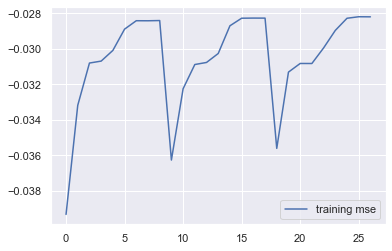

In [57]:
pdf = pd.DataFrame(all_training_scores['mean_train_score'], columns=['training mse'])
pdf.plot()

# Training R2

In [58]:
y_hat = estimator.predict(x_train)

r2_train = metrics.r2_score(y_train, y_hat)
print('R2 (training) = {}'.format(r2_train))

#print("score ", search.score(x_test, y_test))
# or also R-Squared could be obtain via
#pline.score(x_train, y_train)

R2 (training) = 0.4096773734356173


In [59]:
print('Score (training) = {}'.format(search.score(x_train,y_train)))

Score (training) = -0.028120988644279546


In [60]:
estimator.fit(x_train, y_train)

estimator.named_steps.reg.intercept_

/opt/anaconda3/envs/infs890/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


array([0.32387871])

In [61]:
estimator.named_steps.reg.coef_

array([-0.02549347,  0.00752661,  0.00935989, -0.04834642,  0.09868077,
       -0.02779674,  0.0090713 ,  0.05344992,  0.21181909,  0.09119988,
       -0.01512298, -0.01512298, -0.01512298, -0.01512298, -0.01512298,
        0.00752726, -0.18117549])

In [62]:
# validation mean_absolute_percentage_error
train_error =  np.abs(y_train - y_hat)
mean_error = np.mean(train_error)
min_error = np.min(train_error)
max_error = np.max(train_error)
std_error = np.std(train_error)


print("Model Result (mean - std of error - min - max): %.2f (%.2f) %.2f %.2f MSE" \
      % (mean_error, std_error, min_error, max_error))

Model Result (mean - std of error - min - max): 0.10 (0.13) 0.00 0.91 MSE


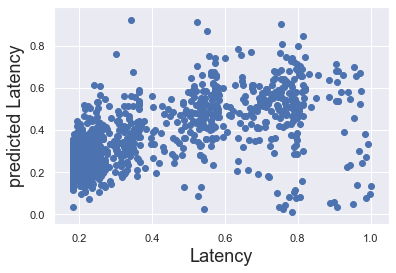

In [63]:
plt.scatter(y_train, y_hat)
plt.xlabel('Latency', size=18)
plt.ylabel("predicted Latency", size=18)
#plt.xlim(-2,3)
#plt.ylim(-3,1)
plt.show()

Text(0.5, 1.0, 'Residual PDF')

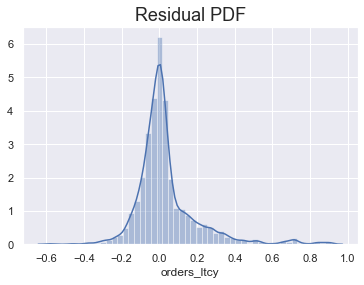

In [64]:
sns.distplot(y_train - y_hat)
plt.title('Residual PDF', size=18)

# Testing

In [65]:
y_hat_test = estimator.predict(x_test)

<function matplotlib.pyplot.show(*args, **kw)>

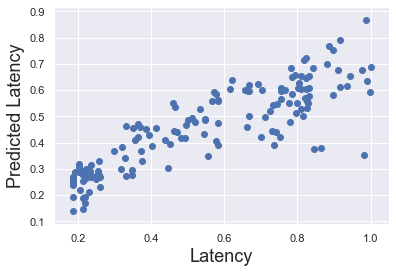

In [66]:
plt.scatter(y_test, y_hat_test)
plt.xlabel('Latency', size=18)
plt.ylabel('Predicted Latency', size=18)
plt.show

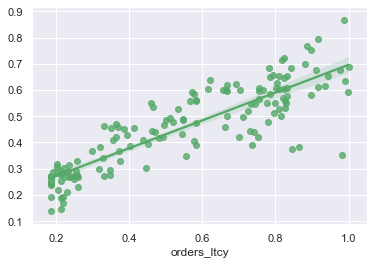

In [67]:
ax = sns.regplot(x=y_test, y=y_hat_test, color='g')

In [68]:
perf = pd.DataFrame(np.exp(y_hat_test), columns=['prediction'])
y_test = y_test.reset_index(drop=True)
perf['target'] = np.exp(y_test)
perf.head()

prediction  target
0      1.2792  1.2048
1      1.3322  1.2467
2      1.3143  1.2658
3      1.3138  1.2840
4      1.2998  1.2840

In [69]:
# testing mean_absolute_percentage_error
perf['residual'] = perf['prediction'] - perf['target']
perf['difference%'] = np.absolute(perf['residual'] * 100 / perf['target'])
perf

prediction  target  residual  difference%
0        1.2792  1.2048    0.0743       6.1694
1        1.3322  1.2467    0.0855       6.8577
2        1.3143  1.2658    0.0485       3.8279
3        1.3138  1.2840    0.0298       2.3215
4        1.2998  1.2840    0.0158       1.2300
..          ...     ...       ...          ...
145      1.8336  2.1268   -0.2932      13.7847
146      1.8064  2.7126   -0.9062      33.4070
147      2.2096  2.5009   -0.2914      11.6508
148      2.3768  2.6881   -0.3113      11.5799
149      1.4208  2.6692   -1.2484      46.7714

[150 rows x 4 columns]

In [70]:
perf.describe()

prediction   target  residual  difference%
count    150.0000 150.0000  150.0000     150.0000
mean       1.5970   1.7858   -0.1888      11.6294
std        0.2547   0.4596    0.2797       9.3160
min        1.1500   1.2048   -1.2484       0.5362
25%        1.3484   1.2981   -0.3701       4.4475
50%        1.5809   1.7370   -0.0906       8.7518
75%        1.8086   2.2090    0.0420      17.6384
max        2.3768   2.7183    0.1953      46.7714

In [71]:
pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.2f' % x)
perf.sort_values(by = ['difference%'])

prediction  target  residual  difference%
101        1.70    1.71     -0.01         0.54
27         1.21    1.20      0.01         0.57
72         1.44    1.45     -0.01         0.58
6          1.31    1.30      0.01         0.80
106        1.80    1.78      0.01         0.82
74         1.75    1.76     -0.02         0.88
21         1.24    1.23      0.01         1.11
4          1.30    1.28      0.02         1.23
33         1.41    1.39      0.02         1.25
105        1.83    1.85     -0.02         1.32
57         1.63    1.65     -0.02         1.44
69         1.89    1.86      0.03         1.70
62         1.64    1.67     -0.03         1.73
24         1.32    1.29      0.02         1.76
35         1.47    1.50     -0.03         1.76
39         1.23    1.26     -0.02         1.85
25         1.32    1.29      0.02         1.92
38         1.35    1.37     -0.03         2.00
49         1.56    1.59     -0.03         2.06
107        1.75    1.79     -0.04         2.10
118        1.81    1.77      0.04         2.19
3          1.31    1.28      0.03         2.32
14         1.21    1.24     -0.03         2.41
136        1.75    1.79     -0.05         2.60
17         1.21    1.25     -0.03         2.63
56         1.51    1.55     -0.04         2.80
58         1.60    1.64     -0.05         2.87
7          1.26    1.30     -0.04         3.02
10         1.55    1.60     -0.05         3.08
23         1.31    1.27      0.04         3.40
5          1.34    1.29      0.05         3.51
60         1.54    1.48      0.05         3.63
26         1.31    1.27      0.05         3.78
2          1.31    1.27      0.05         3.83
16         1.29    1.24      0.05         3.90
67         1.62    1.68     -0.07         3.97
19         1.31    1.25      0.05         4.40
36         1.39    1.46     -0.06         4.44
34         1.58    1.51      0.07         4.46
30         1.15    1.20     -0.05         4.55
18         1.19    1.25     -0.06         4.85
114        1.86    1.95     -0.09         4.86
29         1.27    1.20      0.06         5.16
71         1.35    1.42     -0.07         5.17
63         1.82    1.93     -0.11         5.47
50         1.48    1.57     -0.09         5.50
40         1.27    1.20      0.07         5.58
66         1.51    1.43      0.08         5.60
9          1.52    1.44      0.08         5.71
51         1.31    1.40     -0.08         5.82
68         1.63    1.73     -0.10         5.85
22         1.28    1.20      0.07         6.01
130        1.63    1.73     -0.10         6.05
31         1.34    1.26      0.08         6.17
0          1.28    1.20      0.07         6.17
53         1.32    1.24      0.08         6.32
59         1.52    1.62     -0.10         6.40
109        1.82    1.94     -0.12         6.41
37         1.47    1.38      0.09         6.58
15         1.16    1.24     -0.08         6.66
48         1.57    1.47      0.10         6.72
97         1.86    2.00     -0.14         6.77
41         1.29    1.20      0.08         6.82
1          1.33    1.25      0.09         6.86
141        1.82    1.95     -0.14         6.92
123        1.52    1.64     -0.12         7.13
8          1.44    1.35      0.10         7.17
12         1.32    1.42     -0.10         7.20
79         1.71    1.59      0.12         7.38
32         1.39    1.29      0.10         7.49
28         1.30    1.20      0.10         7.98
52         1.37    1.27      0.10         8.01
47         1.35    1.25      0.10         8.04
20         1.34    1.23      0.10         8.42
45         1.33    1.23      0.11         8.73
43         1.31    1.20      0.11         8.77
42         1.31    1.20      0.11         8.78
108        1.58    1.45      0.13         9.16
90         1.98    2.19     -0.20         9.31
70         2.06    2.28     -0.21         9.41
96         1.74    1.58      0.15         9.68
13         1.33    1.21      0.12         9.74
89         1.82    2.02     -0.20         9.80
133        2.04    2.27     -0.22         9.91
75        

# *** Prediction Accuracy

In [72]:
r2_test = metrics.r2_score(y_test, y_hat_test)
print('R2 (testing) = {}'.format(r2_test))

# also: R-Squared could obtain with
# pline.score(x_test, y_test)

R2 (testing) = 0.5614638442417581


In [73]:
print(np.sqrt(mean_squared_error(y_test,y_hat_test)))

0.17114222711931537
